In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd

## 1. Creating Data to learn ##
Training and test data from Scikit-Learn.

In [26]:
# Make 1000 samples
n_samples = 1000

# Create circles
X,y = make_circles(n_samples, noise=0.03, random_state=42)

## 2. Understanding Data with Pandas and Matplotlib ##

In [3]:
# Visualizing whole data set
def visualize_data():
    plt.figure(figsize=(3,3))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, s=1)
    plt.legend

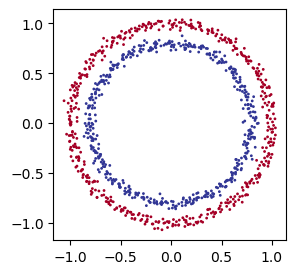

In [4]:
visualize_data()

In [5]:
# Use Pandas DataFrame to get the data into a table
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# Check the shape and type of the input data
# Here we see that we have two inputs for one output and 1000 data samples
X.shape, y.shape

((1000, 2), (1000,))

## 3. Training ##
### a) Preparation for Training ###
Turn the data into tensors for PyTorch and split the data into training and test sets.

In [27]:
# Transforming the arrays into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
# Split the data into train and test set
# Use the train_test_split function from sklearn
# Use random_state to make the result reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### b) Building a model ###

In [16]:
# Using GPU if possible
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [17]:
# 1. Construct a model class as subclass of nn.Module
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create a neural network with one hidden layer with 5 hidden nodes
        self.layer_1 = nn.Linear(in_features=2, out_features=10) 
        self.layer_2 = nn.Linear(in_features=10, out_features=10) 
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # Non-linearity to capture also non-linear data 
        self.relu = nn.ReLU()

        # We could also include the activation function for the logits here
        # self.sigmoid = nn.Sigmoid()
    
    # 3. Define the calculation made in the forward pass
    def forward(self, x):
        # Returns the result after passing x through layer one and two
        return self.layer_3(self.relu(self.layer_2(self.relu((self.layer_1(x))))))

In [28]:
# Create an instance of the model and put it on target device for further calculation
model = ClassificationModel().to(device)

### c) Training the model ### 

In [19]:
# Setting up the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Calculate accuracy based on a prediction and ground truth
def accuracy_function(y_true, y_pred):
    # torch.eq calculates where the two arguments are equal,
    # this gets summed up and turned into a python number
    correct = torch.eq(y_true, y_pred).sum().item()
    # Return the percentage of correctly classified elements
    return (correct / len(y_pred)) * 100

In [20]:
torch.manual_seed(42)

# Set number of epochs
epochs = 2001

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    """
    Training
    """
    model.train()

    # 1. Forward pass to get raw logits, then put activation function on it 
    #    and round the result to get a clear classification to class 0 or 1
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calulcate loss and accuracy
    #    Here we can use the raw logits because we used nn.BCEWithLogitsLoss before
    loss = loss_function(y_logits, y_train)
    acc = accuracy_function(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    """
    Testing
    """
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calulcate loss and accuracy
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_function(y_true=y_test, y_pred=test_pred)

    # Print current state every 10 epochs
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 97.75% | Test loss: 0.40595, Test acc: 92.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 99.50% | Test loss: 0.22108, Test acc: 97.50%
Epoch: 1600 | Loss: 0.09123, Accuracy: 99.88% | Test loss: 0.12741, Test acc: 99.50%
Epoch: 1800 | Loss: 0.05773, Accuracy: 99.88% | Test loss: 0.08672, Test acc: 99.50%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88% | Test loss: 0.06583, Test acc: 100.00%


In [21]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


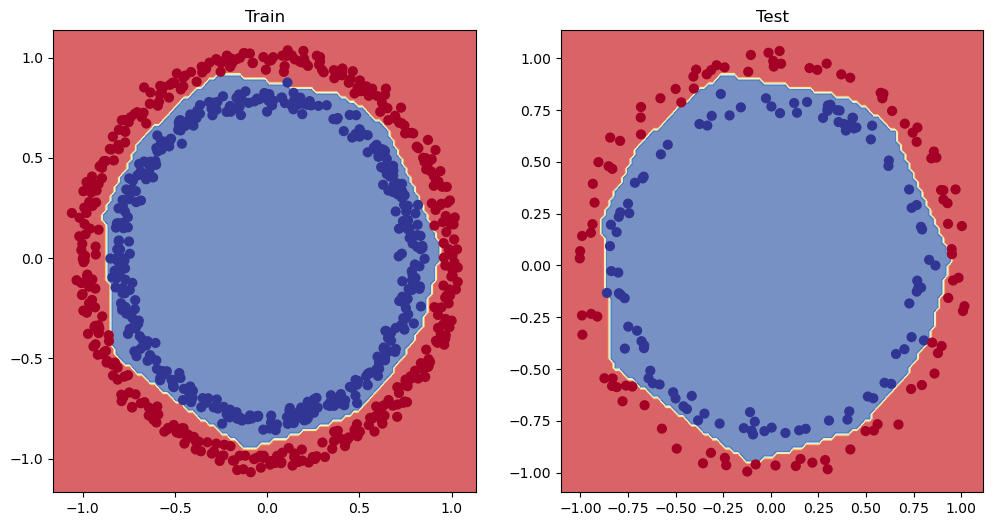

In [22]:
# Visualize the decision boundaries for the training and test set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## 5. Making Predictions ##

In [25]:
# Make predictions on the test data
model.eval()
with torch.inference_mode():
    model.to(device)
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()